# Exoplanet Hunting in Deep Space
Machine Learning project on preprocessed data from the NASA Kepler space telescope. Hosted on Kaggle: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
<br>
The data is labeled and cleaned. The rows represent one solar system. Columns the flux emitted by the system over time. The data gives no information about the time between two measurements. Column "LABEL" indicates if there are exoplanets present in the system. 1 means there are no confirmed exoplanets, 2 means there is at least one confirmed exoplanet in the system.
<br>
If there are exoplanets present the flux curve shows a destingt U-shaped dip. This U-shape is the feature we are looking for

Trainset:

- 5087 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.

Testset:

- 570 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 5 confirmed exoplanet-stars and 565 non-exoplanet-stars.

Data is highly imbalanced this needs to be taken into account
- use precision and recall

In [198]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#timer
from timeit import default_timer as timer

#scipy
from scipy.signal import savgol_filter, periodogram, spectrogram
from scipy.fftpack import fft

#sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

## Preprocessing
### Loading Data and first inspection

In [2]:
#read training data
df_train = pd.read_csv('./exoTrain.csv')
#read test data
df_test = pd.read_csv('./exoTest.csv')

#show head and info of train data
display(df_train.head(3))
df_train.info()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


Flux values are float64 only label has int64
- Transform label into bool

In [3]:
#Check if there are really only two labels
print(df_train['LABEL'].unique())

[2 1]


In [4]:
#transform into bool (minus 1 to give 0 and 1 as labels)
df_train['LABEL'] = (df_train['LABEL'] - 1).astype('bool')
df_train['LABEL'].unique()

array([ True, False])

In [5]:
#same for test
df_test['LABEL'] = (df_test['LABEL'] - 1).astype('bool')

### Missing values

In [6]:
#Are there any missing values at all?
print(f"There are: {df_train.isna().sum().sum()} missing values")

There are: 0 missing values


### Value range and outliers

In [77]:
#min / max / mean / median values for each system
minflux = df_train.iloc[:, 1:].min(axis=1)
maxflux = df_train.iloc[:, 1:].max(axis=1)
meanflux = df_train.iloc[:, 1:].mean(axis=1)
medianflux = df_train.iloc[:, 1:].median(axis=1)

Min    flux value: -2385019.12
Max    flux value:  4299288.0
Mean   flux value:  130.41674038757083
Median flux value: 0.0


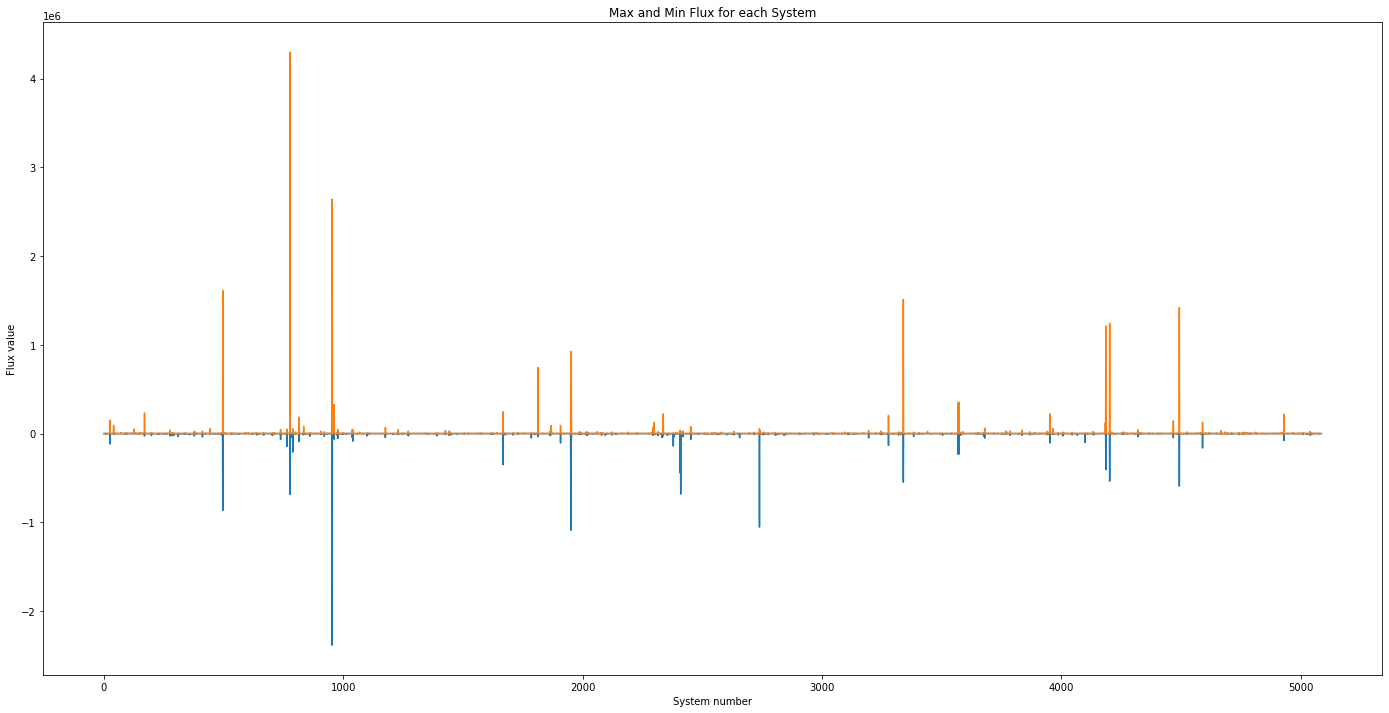

In [93]:
#plot and print min / max / mean / median values
plt.figure(figsize=(24, 12))
plt.plot(np.arange(minflux.shape[0]), minflux)
plt.plot(np.arange(maxflux.shape[0]), maxflux)
plt.title('Max and Min Flux for each System')
plt.ylabel('Flux value')
plt.xlabel('System number')
print(f"Min    flux value: {minflux.min()}")
print(f"Max    flux value:  {maxflux.max()}")
print(f"Mean   flux value:  {meanflux.mean().mean()}")
print(f"Median flux value: {medianflux.median()}")

- wide range of values
- not symmetric
- outliers maybe requiere scaling

### Sample Visualisation

In [64]:
#function to plot first 6 systems of data set
def plot_systems(X):
    plt.figure(1, figsize=(12, 6))
    for i in range(6):
        plt.subplot(2 , 3 , i+1)
        plt.scatter(np.arange(X.shape[1]), X[i], s=1)
    plt.show()

#### With Exoplanets

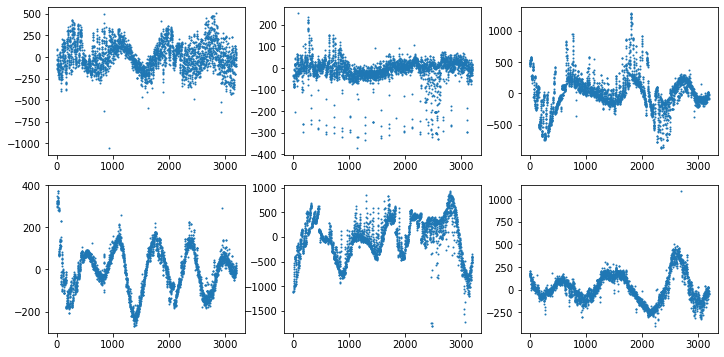

In [65]:
#plot systems with planets
tmp_df = df_train.loc[df_train['LABEL'] == True, 'FLUX.1':].values
plot_systems(tmp_df)

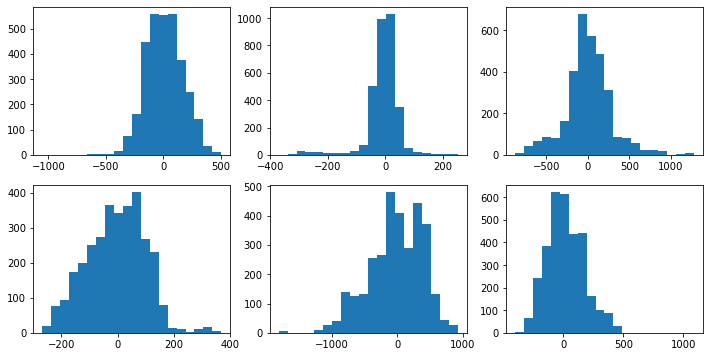

In [66]:
#plot histogram of 6 systems with planets
plt.figure(1, figsize=(12, 6))
for i in range(6):
    plt.subplot(2 , 3 , i+1)
    plt.hist(tmp_df[i], bins=20)
plt.show()

#### Without Exoplanets

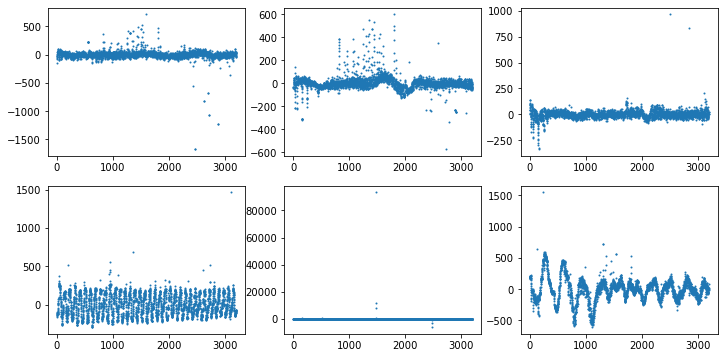

In [68]:
#plot systems without planets
tmp_df = df_train.loc[df_train['LABEL'] == False, 'FLUX.1':].values
plot_systems(tmp_df)

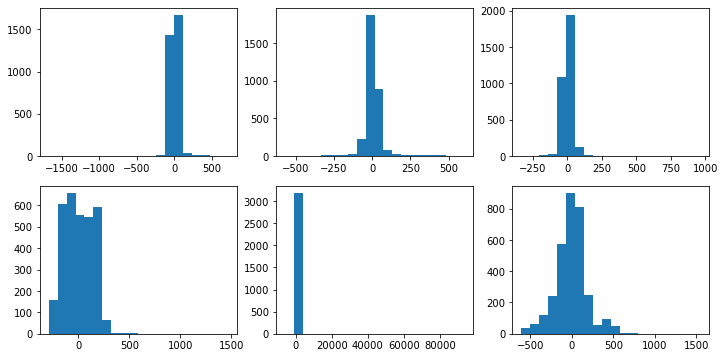

In [71]:
#plot histogram of 6 systems with planets
plt.figure(1, figsize=(12, 6))
for i in range(6):
    plt.subplot(2 , 3 , i+1)
    plt.hist(tmp_df[i], bins=20)
plt.show()

- Periodic changes visible for systems with planets
- Faster periodic changes also visible for systens wihtout planets
    - Use the frequency spectrum for the ML model?
- Noise may hide this changes
- Flux values have different magnitudes
- Histograms seem broader if there are exoplanets present
    - Could we use the histogram for the model?

## Machine Learning Model
### Baseline Models
- First check the difficulty of the problem with a couple of baseline models
    - No further preprocessing or hyperparameter tuning
    - Simple accracy score
- Split train data into train and validation data
    - For hyperparameter tuning I will use cross-validation instead
- Filter data
- Scale data with standard scaler
- Use periodogram instead of features

In [99]:
#Split into train and validate data
X = df_train.iloc[:, 1:].values
y = df_train.iloc[:, :1].values
y = y.reshape(y.shape[0])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

In [100]:
#Seperate test data into labels and data
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, :1].values
y_test = y_test.reshape(y_test.shape[0])

In [106]:
y_train[y_train == True].shape[0]

30

In [108]:
print(f'Samples in trainings data:\t{X_train.shape[0]}\tSystems with Exoplanets: {y_train[y_train == True].shape[0]}')
print(f'Samples in validation data:\t{X_val.shape[0]}\tSystems with Exoplanets: {y_val[y_val == True].shape[0]}')

Samples in trainings data:	4069	Systems with Exoplanets: 30
Samples in validation data:	1018	Systems with Exoplanets: 7


In [114]:
#function to evaluate baseline models
def base_models(X_train, X_test, y_train, y_test):
    #list of baseline models
    model_names = ["Logistic_Regression", "Random_Forest", "AdaBoost", "KNN", "Linear_SVC", "Naive_Bayes"]

    model_list = [LogisticRegression()
               , RandomForestClassifier()
               , AdaBoostClassifier()
               , KNeighborsClassifier()
               , SVC(kernel="linear")
               , GaussianNB()]  
    
    #evaluate all models
    for i, model in enumerate(model_list):
        start = timer()
        model.fit(X_train, y_train)
        y_train_predict = model.predict(X_train)
        y_val_predict = model.predict(X_val)
        print(f'Model: {model_names[i]}')
        #Use f1 Score
        print(f'Trainings  F-Score:\t{metrics.f1_score(y_train, y_train_predict):0.10f}')
        print(f'Validation F-Score:\t{metrics.f1_score(y_val, y_val_predict):0.10f}')
        end = timer()
        print(f'Elapsed Time:\t{end - start:0.4f}s\n')

In [113]:
#baseline on untreated data
base_models(X_train, X_val, y_train, y_val)

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings F-Score:		0.0325732899
Validation F-Score:		0.0213903743
Elapsed Time:	2.0315s

Model: Random_Forest
Trainings F-Score:		1.0000000000
Validation F-Score:		0.0000000000
Elapsed Time:	7.9379s

Model: AdaBoost
Trainings F-Score:		1.0000000000
Validation F-Score:		0.0000000000
Elapsed Time:	69.2436s

Model: KNN
Trainings F-Score:		0.0000000000
Validation F-Score:		0.0000000000
Elapsed Time:	110.1226s

Model: Linear_SVC
Trainings F-Score:		1.0000000000
Validation F-Score:		0.0487804878
Elapsed Time:	21.3280s

Model: Naive_Bayes
Trainings F-Score:		0.0145254195
Validation F-Score:		0.0139165010
Elapsed Time:	0.3898s



- Random Forest, AdaBoost and Linear SVC are overfitting the data
- KNN and AdaBoost take to long to train
- Try to reduce overfitting of random forest
- Improve data quality by preprocessing
    - denoising
    - frequency analysis
    - PCA

### Random Forest
#### Hyperparameter tuning with Random Search
Tune for
- Estimators
- max depth
- min leafs
- max features
- criterion

In [127]:
#lists of hyperparameters to tune
random_params = {'criterion': ['entropy', 'gini']
                , 'max_depth' : [10, 100, 1000, None]
                ,'n_estimators' : [50, 100, 200, 500]
                , 'min_samples_leaf' : [1, 5, 10]
                , 'min_samples_split': [5, 10, 15]
                , 'max_features' : ['auto', 'log2']}

#random search
forest_random_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=random_params,
                                      scoring='f1', n_iter=100, cv=5, n_jobs=-1, verbose=10, random_state=4321)
forest_random_cv.fit(X, y)

y_predict = forest_random_cv.predict(X)
#Use f1 Score
print(f'F-Score:\t{metrics.f1_score(y, y_predict):0.4f}')
print(f'Best model: {forest_random_cv.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11

F-Score:	0.0000
Best model: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy'}


- no improvement

#### Baseline on Filtered data
I use Savitzky-Golay-Filter because it keeps distinct features of data

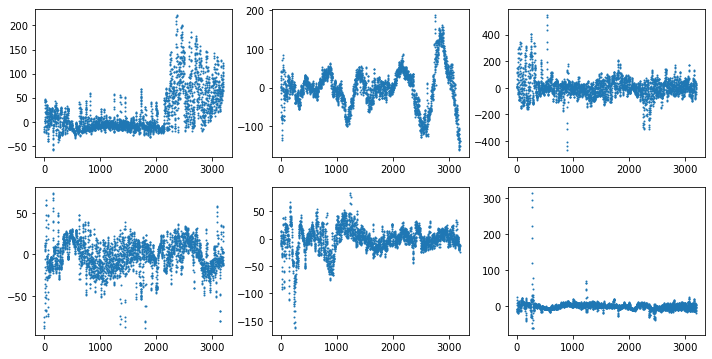

In [219]:
#Filter input
X_train_filtered = savgol_filter(X_train, window_length=25, polyorder=8)
X_val_filtered = savgol_filter(X_val, window_length=25, polyorder=8)
plot_systems(X_train_filtered)

In [210]:
base_models(X_train_filtered, X_val_filtered, y_train, y_val)

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Model: Logistic_Regression
Trainings  F-Score:	0.0273794003
Validation F-Score:	0.0131868132
Elapsed Time:	2.1434s

Model: Random_Forest
Trainings  F-Score:	1.0000000000
Validation F-Score:	0.0000000000
Elapsed Time:	8.2300s

Model: AdaBoost
Trainings  F-Score:	1.0000000000
Validation F-Score:	0.0000000000
Elapsed Time:	74.8760s

Model: KNN
Trainings  F-Score:	0.0000000000
Validation F-Score:	0.0000000000
Elapsed Time:	111.1709s

Model: Linear_SVC
Trainings  F-Score:	1.0000000000
Validation F-Score:	0.0338983051
Elapsed Time:	32.1850s

Model: Naive_Bayes
Trainings  F-Score:	0.0145108832
Validation F-Score:	0.0139026812
Elapsed Time:	0.3867s



- no changes in performance

#### Baseline on Spectrum

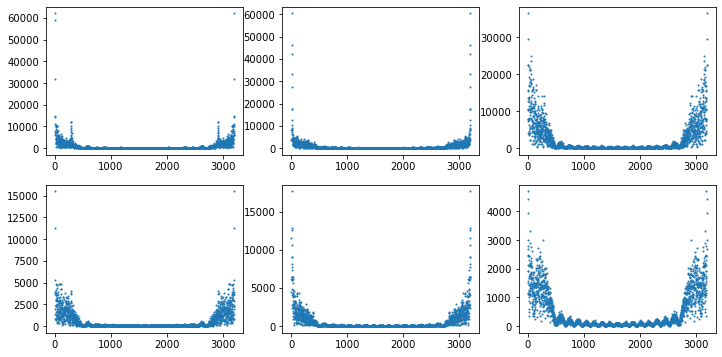

In [231]:
#Calc spectrum
X_train_period = np.abs(fft(X_train_filtered, axis=1))
X_val_period = np.abs(fft(X_val_filtered, axis=1))
plot_systems(X_train_period)

#### Baseline on scaled data
Use Standard Scaler

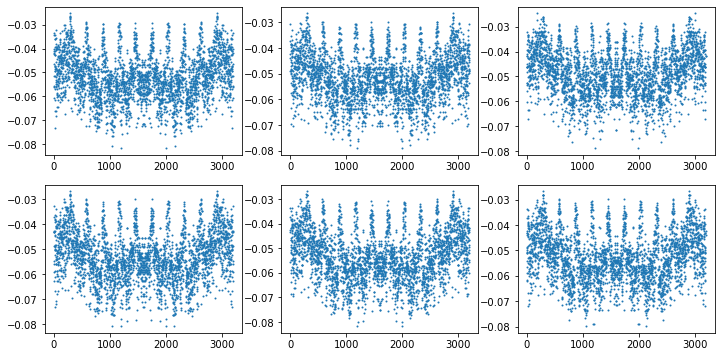

In [232]:
#scale input
std_scaler = StandardScaler()
std_scaler.fit(X_train_period)
X_train_scaled = std_scaler.transform(X_train_period)
X_val_scaled = std_scaler.transform(X_val_period)
plot_systems(X_train_scaled)

In [213]:
base_models(X_train_scaled, X_val_scaled, y_train, y_val)

Model: Logistic_Regression
Trainings  F-Score:	0.0645161290
Validation F-Score:	0.0079840319
Elapsed Time:	1.5977s

Model: Random_Forest
Trainings  F-Score:	1.0000000000
Validation F-Score:	0.0138888889
Elapsed Time:	8.8128s

Model: AdaBoost
Trainings  F-Score:	1.0000000000
Validation F-Score:	0.0000000000
Elapsed Time:	69.0730s

Model: KNN
Trainings  F-Score:	0.0000000000
Validation F-Score:	0.0000000000
Elapsed Time:	83.6019s

Model: Linear_SVC
Trainings  F-Score:	0.3333333333
Validation F-Score:	0.0076923077
Elapsed Time:	5.8082s

Model: Naive_Bayes
Trainings  F-Score:	0.0143209877
Validation F-Score:	0.0000000000
Elapsed Time:	0.3985s



- No changes
#### Baseline with PCA
- Should improve performance
- 0.9 is just a guess will be improved later with grid and random search

In [222]:
#reduce features with PCA
pca = PCA(n_components=0.9)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [223]:
base_models(X_train_scaled, X_val_scaled, y_train, y_val)

Model: Logistic_Regression
Trainings  F-Score:	0.0645161290
Validation F-Score:	0.0079840319
Elapsed Time:	1.5927s

Model: Random_Forest
Trainings  F-Score:	1.0000000000
Validation F-Score:	0.0152671756
Elapsed Time:	9.5930s

Model: AdaBoost
Trainings  F-Score:	1.0000000000
Validation F-Score:	0.0000000000
Elapsed Time:	72.0138s

Model: KNN
Trainings  F-Score:	0.0000000000
Validation F-Score:	0.0000000000
Elapsed Time:	84.2493s

Model: Linear_SVC
Trainings  F-Score:	0.3333333333
Validation F-Score:	0.0076923077
Elapsed Time:	6.1488s

Model: Naive_Bayes
Trainings  F-Score:	0.0143209877
Validation F-Score:	0.0000000000
Elapsed Time:	0.4213s



- implement pipeline with all preprocessing steps
- use LogRegression seems to show good performance and is fast

### Custom transformer classes for pipeline

In [236]:
#Transformer class for Filter
class SavogolFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window_length=21, polyorder=4):
        self.window_length = window_length
        self.polyorder = polyorder
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        return savgol_filter(X, window_length=self.window_length, polyorder=self.polyorder)
    
    
#Transformer class for spectrum
class Spectrum(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        return np.abs(fft(X))

### Logistic Regression Classifier
#### Pipeline for all steps

In [246]:
transform_pipe = Pipeline(steps=[
                        ('savogol_filter', SavogolFilter())
                        ,('spectrum', Spectrum())
                        ,('std_scaler', StandardScaler())
                        ,('pca', PCA(n_components=0.9))
                         ])

In [247]:
transform_pipe.fit(X, y)
X_trans = transform_pipe.transform(X)

In [249]:
#lists of hyperparameters to tune
random_params = {'criterion': ['entropy', 'gini']
                , 'max_depth' : [10, 100, 1000, None]
                , 'n_estimators' : [50, 100, 200, 500]
                , 'min_samples_leaf' : [1, 5, 10]
                , 'min_samples_split': [5, 10, 15]
                , 'max_features' : ['auto', 'log2']}

#random search
forest_random_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=random_params,
                                      scoring='f1', n_iter=100, cv=5, n_jobs=-1, verbose=10, random_state=4321)
forest_random_cv.fit(X_trans, y)

y_predict = forest_random_cv.predict(X_trans)
#Use f1 Score
print(f'Confusion Matrix:\n{confusion_matrix(y, y_predict)}')
print(f'Classification report:\n{classification_report(y, y_predict)}')
print(f'Best model: {forest_random_cv.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Confusion Matrix:
[[5050    0]
 [  37    0]]
Classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      5050
        True       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087

Best model: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy'}


/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
print(f'Training Score:\t{logpipe_random_cv.score(X_train, y_train)}')
print(f'Validate Score:\t{logpipe_random_cv.score(X_val, y_val)}')
print(f'Best model: {logpipe_random_cv.best_params_}')

y_val_predicted = logpipe_random_cv.best_estimator_.predict(X_val)
print(f'Confusion Matrix:\n{confusion_matrix(y_val, y_val_predicted)}')
print(f'Classification report:\n{classification_report(y_val, y_val_predicted)}')

Training Score:	0.9926271811255837
Validate Score:	0.9931237721021611
Best model: {'pca__n_components': 1000, 'log_regression__max_iter': 200, 'log_regression__fit_intercept': True, 'log_regression__C': 10}
Confusion Matrix:
[[1011    0]
 [   7    0]]
Classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1011
        True       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018



/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
#lists of hyperparameters to tune
grid_params = {'pca__n_components': [1500, 1250, 1000, 750, 500]
                , 'log_regression__C' : [5, 10, 15]
                , 'log_regression__max_iter' : [150, 200, 250]
                }

#grid search
logpipe_grid_cv = GridSearchCV(logreg_pipe, param_grid=grid_params, cv=5, n_jobs=-1, verbose=10)
logpipe_grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('wiener_filter', WienerFilter()),
                                       ('std_scaler', StandardScaler()),
                                       ('periodogram', Periodogram()),
                                       ('pca', PCA(n_components=1000)),
                                       ('log_regression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log_regression__C': [5, 10, 15],
                         'log_regression__max_iter': [150, 200, 250],
                         'pca__n_components': [1500, 1250, 1000, 750, 500]},
             verbose=10)

In [84]:
print(f'Training Score:\t{logpipe_grid_cv.score(X_train, y_train)}')
print(f'Validate Score:\t{logpipe_grid_cv.score(X_val, y_val)}')
print(f'Best model: {logpipe_grid_cv.best_params_}')

y_val_predicted = logpipe_grid_cv.best_estimator_.predict(X_val)
print(f'Confusion Matrix:\n{confusion_matrix(y_val, y_val_predicted)}')
print(f'Classification report:\n{classification_report(y_val, y_val_predicted)}')

Training Score:	0.9921356598672892
Validate Score:	0.9921414538310412
Best model: {'log_regression__C': 5, 'log_regression__max_iter': 150, 'pca__n_components': 1250}
Confusion Matrix:
[[1010    1]
 [   7    0]]
Classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1011
        True       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018



In [85]:
#lists of hyperparameters to tune
grid_params = {'pca__n_components': [1000]
                , 'log_regression__C' : [1, 2.5, 5, 7.5, 10, 12.5]
                , 'log_regression__max_iter' : [200]
                }

#grid search
logpipe_grid_cv = GridSearchCV(logreg_pipe, param_grid=grid_params, cv=5, n_jobs=-1, verbose=10)
logpipe_grid_cv.fit(X_train, y_train)

print(f'Training Score:\t{logpipe_grid_cv.score(X_train, y_train)}')
print(f'Validate Score:\t{logpipe_grid_cv.score(X_val, y_val)}')
print(f'Best model: {logpipe_grid_cv.best_params_}')

y_val_predicted = logpipe_grid_cv.best_estimator_.predict(X_val)
print(f'Confusion Matrix:\n{confusion_matrix(y_val, y_val_predicted)}')
print(f'Classification report:\n{classification_report(y_val, y_val_predicted)}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.8min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.9min remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.2min remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished
/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Training Score:	0.9926271811255837
Validate Score:	0.9931237721021611
Best model: {'log_regression__C': 7.5, 'log_regression__max_iter': 200, 'pca__n_components': 1000}
Confusion Matrix:
[[1011    0]
 [   7    0]]
Classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1011
        True       0.00      0.00      0.00         7

    accuracy                           0.99      1018
   macro avg       0.50      0.50      0.50      1018
weighted avg       0.99      0.99      0.99      1018



/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
best_logreg = logpipe_grid_cv.best_estimator_.fit(X, y)

/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [89]:
df_test = pd.read_csv('./exoTest.csv')
df_test['LABEL'] = (df_test['LABEL'] - 1).astype('bool')
#Split into test and validate data
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, :1].values
y_test = y_test.reshape(y_test.shape[0])

In [90]:
y_test_predicted = best_logreg.predict(X_test)
print(f'Test Score:\t{accuracy_score(y_test, y_test_predicted)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_test_predicted)}')
print(f'Classification report:\n{classification_report(y_test, y_test_predicted)}')

Test Score:	0.9912280701754386
Confusion Matrix:
[[565   0]
 [  5   0]]
Classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       565
        True       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Hyperparameter tuning with Random Search
Tune for
- Estimators
- max depth
- min leafs
- max features
- criterion

In [21]:
#lists of hyperparameters to tune
random_params = {'criterion': ['entropy', 'gini']
                , 'max_depth' : [10, 100, 1000, None]
                ,'n_estimators' : [50, 100, 200, 500]
                , 'min_samples_leaf' : [1, 5, 10]
                , 'min_samples_split': [5, 10, 15]
                , 'max_features' : ['auto', 'log2']}

#random search
forest_random_cv = GridSearchCV(RandomForestClassifier(), param_distributions=random_params,
                                      n_iter=50, cv=3, n_jobs=-1, verbose=10, random_state=4321)
forest_random_cv.fit(X_train_period, y_train)

print(f'Training Score:\t{forest_random_cv.score(X_train_period, y_train)}')
print(f'Validate Score:\t{forest_random_cv.score(X_val_period, y_val)}')
print(f'Best model: {forest_random_cv.best_params_}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min


KeyboardInterrupt: 

In [ ]:
y_val_predicted = forest_random_cv.best_estimator_.predict(X_val_period)
print(confusion_matrix(y_val, y_val_predicted))
print(classification_report(y_val, y_val_predicted))
print(accuracy_score(y_val, y_val_predicted))

In [ ]:
#lists of hyperparameters to tune
grid_params = {'criterion': [forest_random_cv.best_params_['criterion']]
                , 'max_features' : [forest_random_cv.best_params_['max_features']]
                ,'n_estimators' : [forest_random_cv.best_params_['n_estimators']]                   
                , 'max_depth' : [forest_random_cv.best_params_['max_depth'] - 5
                                , forest_random_cv.best_params_['max_depth']
                                , forest_random_cv.best_params_['max_depth'] + 5]
                , 'min_samples_leaf' : [forest_random_cv.best_params_['min_samples_leaf'] - 2
                                       , forest_random_cv.best_params_['min_samples_leaf']
                                       , forest_random_cv.best_params_['min_samples_leaf'] + 2]
                , 'min_samples_split': [forest_random_cv.best_params_['min_samples_split'] - 3
                                       , forest_random_cv.best_params_['min_samples_split']
                                       , forest_random_cv.best_params_['min_samples_split'] + 3]
              }

#grid search
forest_grid_cv = GridSearchCV(RandomForestClassifier(), param_grid=grid_params, cv=3, n_jobs=-1, verbose=10)
forest_grid_cv.fit(X_train_period, y_train)

print(f'Training Score:\t{forest_grid_cv.score(X_train_period, y_train)}')
print(f'Validate Score:\t{forest_grid_cv.score(X_val_period, y_val)}')
print(f'Best model: {forest_grid_cv.best_params_}')

In [ ]:
y_val_predicted = forest_grid_cv.best_estimator_.predict(X_val_period)
print(confusion_matrix(y_val, y_val_predicted))
print(classification_report(y_val, y_val_predicted))
print(accuracy_score(y_val, y_val_predicted))

- Apperantly there are no changes if I change imput...